In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/salecars/Car_sales.csv


In [128]:
import pandas as pd
import numpy as np
#import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels as sm
import scipy.stats as stats
import sklearn as sk

In [129]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [130]:
cars=pd.read_csv("../input/salecars/Car_sales.csv")

In [131]:
cars.head(2)

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.5,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.4,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778


In [132]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
Manufacturer              157 non-null object
Model                     157 non-null object
Sales_in_thousands        157 non-null float64
four_year_resale_value    121 non-null float64
Vehicle_type              157 non-null object
Price_in_thousands        155 non-null float64
Engine_size               156 non-null float64
Horsepower                156 non-null float64
Wheelbase                 156 non-null float64
Width                     156 non-null float64
Length                    156 non-null float64
Curb_weight               155 non-null float64
Fuel_capacity             156 non-null float64
Fuel_efficiency           154 non-null float64
Latest_Launch             157 non-null object
Power_perf_factor         155 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.8+ KB


In [133]:
# separating continuous and categorical vars.

cars_con=cars.select_dtypes(exclude='object')
cars_cat=cars.select_dtypes(include='object')
# # #
print(cars_con.columns)
print('\n',cars_cat.columns)

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')

 Index(['Manufacturer', 'Model', 'Vehicle_type', 'Latest_Launch'], dtype='object')


## Creating UDFs

In [134]:
#descriptive stats of continuous vars.

def cont_stats(x):
    return pd.Series({'cnt':x.count(),'nans':x.isnull().sum(),'uniqs':x.value_counts().count(),'sum':x.sum(),
                          'mean':x.mean(),'median':x.median(),'std':x.std(),'min':x.min(),'P1':x.quantile(0.01),'P5':x.quantile(0.05),
                              'P10':x.quantile(0.1),'P25':x.quantile(0.25),'P50':x.quantile(0.5),'P75':x.quantile(0.75),'P90':x.quantile(0.90),
                                  'P99':x.quantile(0.99),'max':x.max()})

In [135]:
#descriptive stats of categorical vars.

def cat_stats(y):
    md=y.mode()[0]   #incase multimodal take first instance
    freq=y.value_counts().sort_values(ascending=False)[0]
    return pd.Series({'cnt':y.count(),'nans':y.isnull().sum(),'uniqs':y.value_counts().count(),
                         'mode':md,'frequency':freq})

In [136]:
# missing vals imputation

def misses(z):
    if ((z.dtype=='int64')|(z.dtype=='float64')):
        z.fillna(z.mean(),inplace=True)
    else:
        z.fillna(z.mode,inplace=True)

In [137]:
# dummy vars creator

def dums(df,col):
    dum_col=pd.get_dummies(df[col],prefix='Dum',drop_first=True)
    df.drop(columns=col,inplace=True)
    df=pd.concat([df,dum_col],axis=1)
    return df

## Descriptive Stats

In [138]:
# categorical vars
cars_cat.apply(cat_stats).T

,cnt,nans,uniqs,mode,frequency
Manufacturer,157,0,30,Dodge,11
Model,157,0,156,Neon,2
Vehicle_type,157,0,2,Passenger,116
Latest_Launch,157,0,130,1/24/2011,2


In [139]:
# continuous vars
cars_con.apply(cont_stats).T.round(2)

,cnt,nans,uniqs,sum,mean,median,std,min,P1,P5,P10,P25,P50,P75,P90,P99,max
Sales_in_thousands,157.0,0.0,157.0,8320.70,53.00,29.45,68.03,0.11,0.94,1.87,5.45,14.11,29.45,67.96,127.64,260.65,540.56
four_year_resale_value,121.0,36.0,117.0,2186.83,18.07,14.18,11.45,5.16,6.17,7.85,9.12,11.26,14.18,19.88,32.08,60.22,67.55
Price_in_thousands,155.0,2.0,152.0,4245.57,27.39,22.80,14.35,9.24,10.23,12.47,13.97,18.02,22.80,31.95,44.02,78.48,85.50
Engine_size,156.0,1.0,31.0,477.50,3.06,3.00,1.04,1.00,1.56,1.80,1.95,2.30,3.00,3.58,4.60,5.70,8.00
Horsepower,156.0,1.0,66.0,29008.00,185.95,177.50,56.70,55.00,96.40,114.50,120.00,149.50,177.50,215.00,254.00,325.75,450.00
Wheelbase,156.0,1.0,88.0,16768.00,107.49,107.00,7.64,92.60,92.88,95.87,98.65,103.00,107.00,112.20,115.50,134.37,138.70
Width,156.0,1.0,78.0,11099.40,71.15,70.55,3.45,62.60,66.09,66.50,66.90,68.40,70.55,73.43,76.20,79.19,79.90
Length,156.0,1.0,127.0,29225.60,187.34,187.90,13.43,149.40,154.92,163.68,173.00,177.58,187.90,196.12,203.40,219.30,224.50
Curb_weight,155.0,2.0,147.0,523.59,3.38,3.34,0.63,1.90,2.25,2.42,2.61,2.97,3.34,3.80,4.12,5.40,5.57
Fuel_capacity,156.0,1.0,55.0,2800.50,17.95,17.20,3.89,10.30,11.90,12.50,13.20,15.80,17.20,19.58,23.20,30.90,32.00


## Outlier treatment

* For most vars, there is lot of gap b/w 1st percentile & min value, 99 percentile and max value, hence clip those outliers to 1 and 99 percentile

In [140]:
cars_con = cars_con.apply(lambda v :v.clip(lower=v.quantile(0.01),upper=v.quantile(0.99)))

In [141]:
cars_con.apply(cont_stats).T.round(2)  # all outliers clipped to 1 and 99 percentiles

,cnt,nans,uniqs,sum,mean,median,std,min,P1,P5,P10,P25,P50,P75,P90,P99,max
Sales_in_thousands,157.0,0.0,155.0,8025.53,51.12,29.45,57.72,0.94,0.95,1.87,5.45,14.11,29.45,67.96,127.64,253.56,260.65
four_year_resale_value,121.0,36.0,115.0,2180.42,18.02,14.18,11.18,6.17,6.42,7.85,9.12,11.26,14.18,19.88,32.08,59.90,60.22
Price_in_thousands,155.0,2.0,150.0,4235.96,27.33,22.80,14.06,10.23,10.48,12.47,13.97,18.02,22.80,31.95,44.02,76.58,78.48
Engine_size,156.0,1.0,29.0,475.81,3.05,3.00,0.98,1.56,1.58,1.80,1.95,2.30,3.00,3.58,4.60,5.70,5.70
Horsepower,156.0,1.0,64.0,28910.30,185.32,177.50,52.82,96.40,98.38,114.50,120.00,149.50,177.50,215.00,254.00,317.09,325.75
Wheelbase,156.0,1.0,87.0,16760.10,107.44,107.00,7.42,92.88,93.00,95.87,98.65,103.00,107.00,112.20,115.50,132.52,134.37
Width,156.0,1.0,76.0,11102.45,71.17,70.55,3.39,66.09,66.26,66.50,66.90,68.40,70.55,73.43,76.20,79.14,79.19
Length,156.0,1.0,125.0,29223.94,187.33,187.90,13.12,154.92,156.23,163.68,173.00,177.58,187.90,196.12,203.40,217.10,219.30
Curb_weight,155.0,2.0,145.0,523.77,3.38,3.34,0.62,2.25,2.25,2.42,2.61,2.97,3.34,3.80,4.12,5.39,5.40
Fuel_capacity,156.0,1.0,54.0,2799.90,17.95,17.20,3.82,11.90,11.90,12.50,13.20,15.80,17.20,19.58,23.20,30.40,30.90


## Missing values treatment

In [142]:
cars_con.apply(misses) #missing imputation
cars_con.apply(cont_stats).T.round(2)

,cnt,nans,uniqs,sum,mean,median,std,min,P1,P5,P10,P25,P50,P75,P90,P99,max
Sales_in_thousands,157.0,0.0,155.0,8025.53,51.12,29.45,57.72,0.94,0.95,1.87,5.45,14.11,29.45,67.96,127.64,253.56,260.65
four_year_resale_value,157.0,0.0,116.0,2829.14,18.02,17.71,9.81,6.17,6.87,8.42,9.71,12.54,17.71,18.14,27.02,59.31,60.22
Price_in_thousands,157.0,0.0,151.0,4290.61,27.33,23.40,13.97,10.23,10.49,12.49,13.98,18.14,23.40,31.93,43.79,76.51,78.48
Engine_size,157.0,0.0,30.0,478.86,3.05,3.00,0.98,1.56,1.58,1.80,1.96,2.30,3.00,3.50,4.60,5.70,5.70
Horsepower,157.0,0.0,65.0,29095.62,185.32,180.00,52.65,96.40,98.42,114.60,120.00,150.00,180.00,215.00,253.80,316.93,325.75
Wheelbase,157.0,0.0,88.0,16867.54,107.44,107.00,7.40,92.88,93.00,95.92,98.70,103.00,107.00,112.20,115.46,132.48,134.37
Width,157.0,0.0,77.0,11173.62,71.17,70.60,3.38,66.09,66.26,66.50,66.90,68.40,70.60,73.40,76.18,79.14,79.19
Length,157.0,0.0,126.0,29411.27,187.33,187.80,13.08,154.92,156.25,163.70,173.12,177.60,187.80,196.10,203.34,217.06,219.30
Curb_weight,157.0,0.0,146.0,530.53,3.38,3.37,0.62,2.25,2.25,2.42,2.61,2.98,3.37,3.78,4.12,5.39,5.40
Fuel_capacity,157.0,0.0,55.0,2817.85,17.95,17.20,3.81,11.90,11.90,12.50,13.20,15.80,17.20,19.50,23.20,30.40,30.90


## Converting Categorical vars.

In [143]:
cars_cat=cars_cat[['Manufacturer','Vehicle_type']]  #taking just the imp. categorical vars.

In [144]:
for x in ['Manufacturer','Vehicle_type']:
    cars_cat[x]=cars_cat[x].astype('category')
    cars_cat=dums(cars_cat,x)

In [145]:
cars_final=pd.concat([cars_con,cars_cat],axis=1)  #create final dataframe-combine numerical and categorical vars.
cars_final.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Dum_Plymouth,Dum_Pontiac,Dum_Porsche,Dum_Saab,Dum_Saturn,Dum_Subaru,Dum_Toyota,Dum_Volkswagen,Dum_Volvo,Dum_Passenger
0,16.919,16.360,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1


#############################################################################################################################

#### 1.Normality

1.9734059838643523


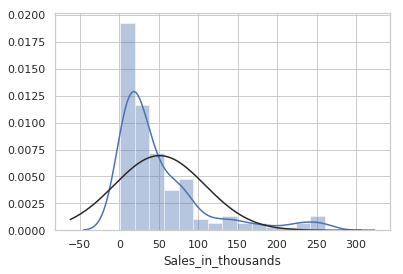

In [146]:
sns.set(style='whitegrid')
sns.distplot(cars_final['Sales_in_thousands'],fit=stats.norm)
print(stats.skew(cars_final['Sales_in_thousands']))

High skew of our dependant var, hence apply log transformation.

In [147]:
cars_final['ln_Sales_in_thousands']=np.log(cars_final['Sales_in_thousands']+1)  # +1 bcoz, if any value in sales column is zero->ln(0)=not_defined

-0.32609276879651655


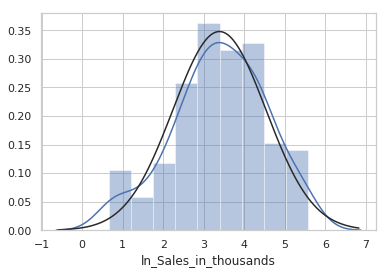

In [148]:
sns.distplot(cars_final['ln_Sales_in_thousands'],fit=stats.norm)
print(stats.skew(cars_final['ln_Sales_in_thousands']))

After log transform, our dependant var, is forced to be near normal, and skewness is also within acceptable range.

#### 2.Multi-Collinearity Check

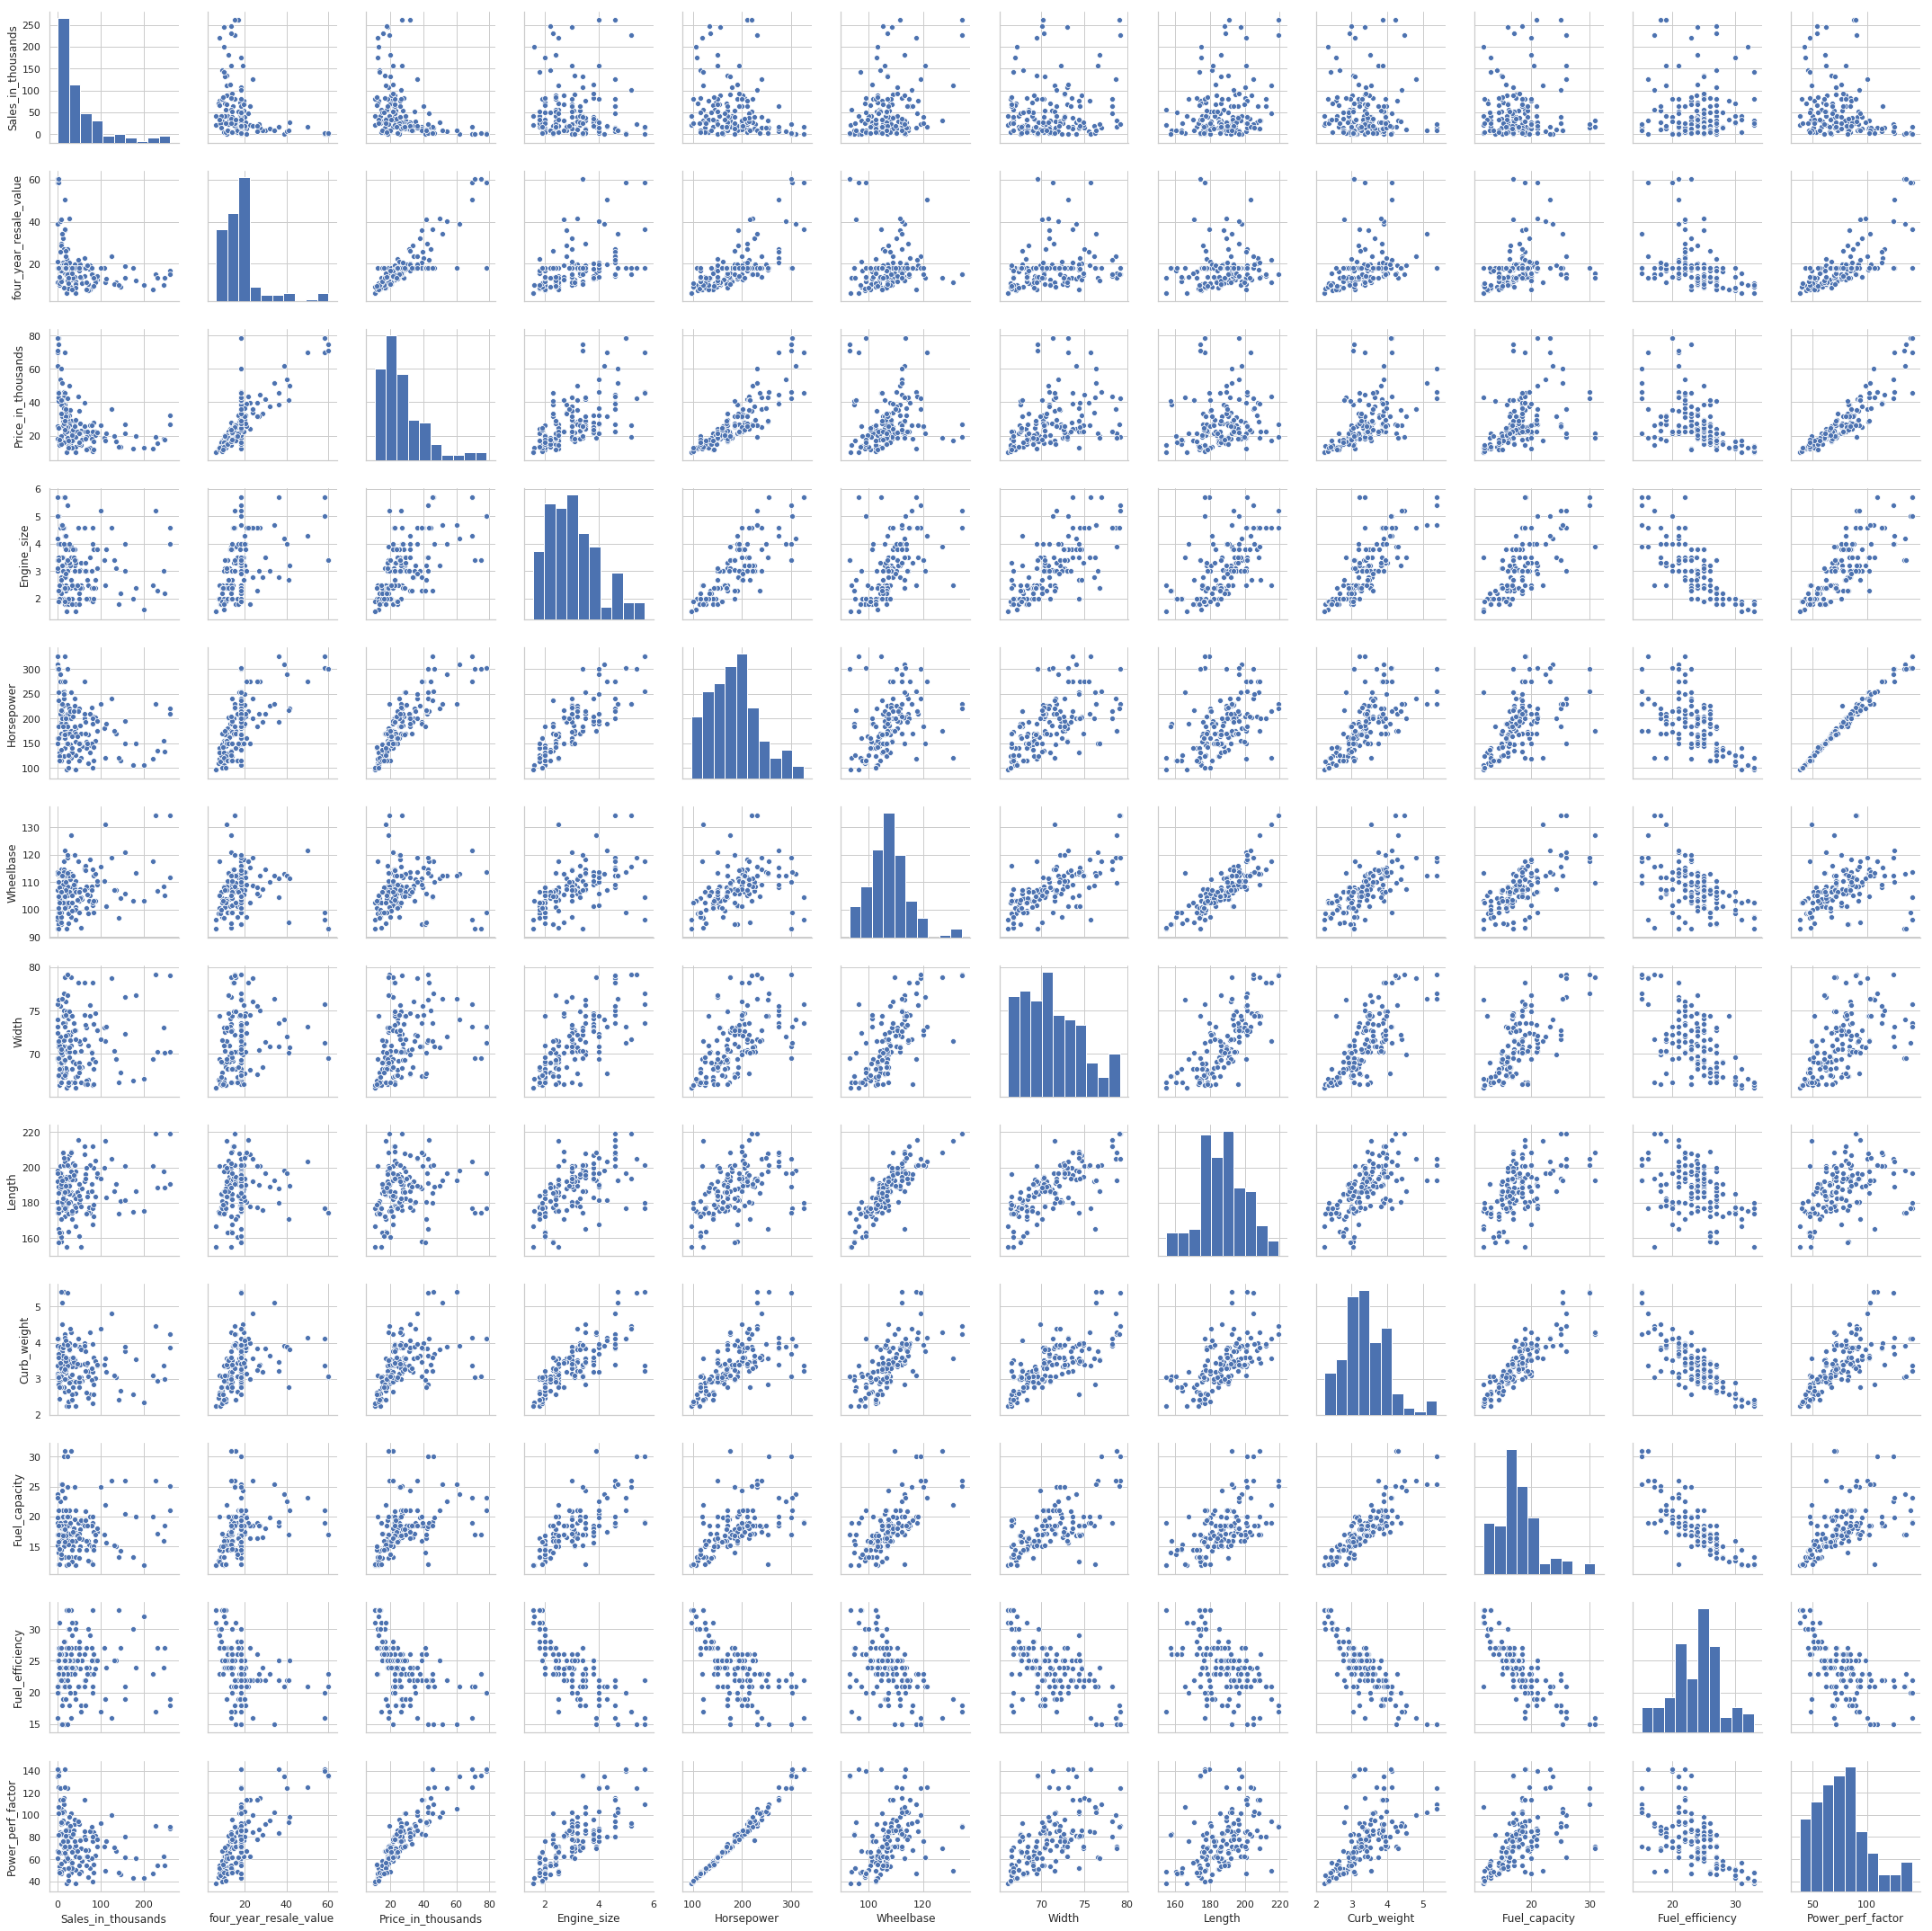

In [149]:
#visualising collinearity 
sns.pairplot(cars_final[['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor']])

In [150]:
corrmat=cars_final.corr()  #correlation among numeric vars.
corrmat.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Dum_Pontiac,Dum_Porsche,Dum_Saab,Dum_Saturn,Dum_Subaru,Dum_Toyota,Dum_Volkswagen,Dum_Volvo,Dum_Passenger,ln_Sales_in_thousands
Sales_in_thousands,1.000000,-0.307538,-0.361572,-0.014342,-0.259311,0.278280,0.093054,0.200997,-0.035282,0.044446,...,0.036853,-0.114192,-7.988584e-02,-0.054683,-2.181588e-02,0.133404,-0.056294,-1.333610e-01,-0.230252,0.828538
four_year_resale_value,-0.307538,1.000000,0.832320,0.440258,0.679605,-0.037624,0.158211,0.025517,0.304378,0.284274,...,-0.071303,0.512245,3.225261e-17,-0.087128,3.225261e-17,-0.030552,-0.062450,5.386266e-17,0.076638,-0.470239
Price_in_thousands,-0.361572,0.832320,1.000000,0.618230,0.849851,0.118080,0.328107,0.158161,0.527230,0.430942,...,-0.062676,0.352160,1.860392e-02,-0.170025,-4.839044e-02,-0.094643,-0.137820,5.158511e-02,0.042006,-0.566486
Engine_size,-0.014342,0.440258,0.618230,1.000000,0.815010,0.518423,0.702618,0.576386,0.793937,0.698341,...,0.078278,0.016675,-1.047543e-01,-0.191415,-6.401942e-02,-0.108099,-0.221271,-1.531916e-01,-0.279272,-0.109526
Horsepower,-0.259311,0.679605,0.849851,0.815010,1.000000,0.325247,0.538115,0.420472,0.637823,0.526554,...,-0.001225,0.231413,-1.693190e-02,-0.227139,-4.398854e-02,-0.115857,-0.244956,-1.198690e-02,-0.011910,-0.392894


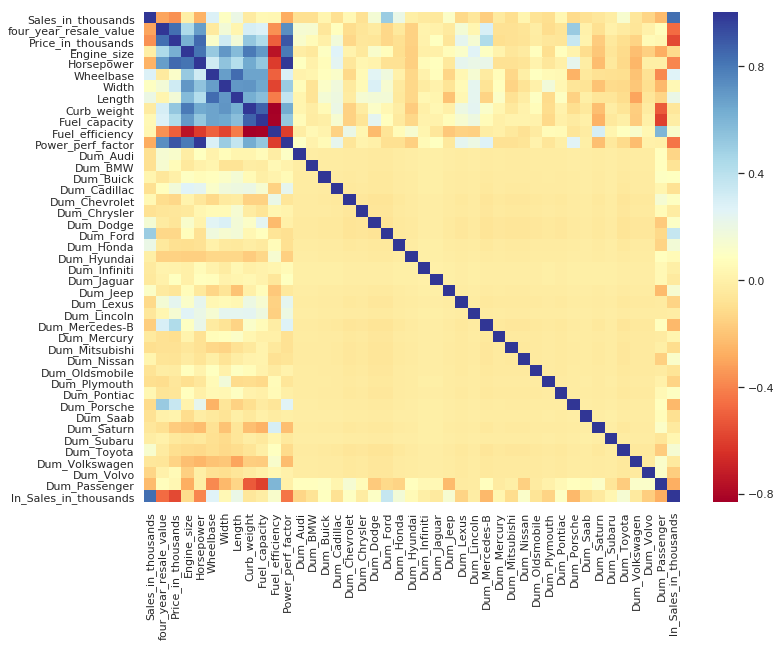

In [151]:
# visualizing through heatmaps
plt.figure(figsize=(12,9))
sns.heatmap(corrmat,cmap='RdYlBu')  #checking for multi-collinearity

Since most of the heatmap is yellow, i.e correlation is zero for most variables, we say multi-collinearity though present is less.

#### Train-test split

In [152]:
#data splitting into train and test
train,test=train_test_split(cars_final,test_size=0.3,random_state=3994)
train.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Dum_Pontiac,Dum_Porsche,Dum_Saab,Dum_Saturn,Dum_Subaru,Dum_Toyota,Dum_Volkswagen,Dum_Volvo,Dum_Passenger,ln_Sales_in_thousands
69,157.040,18.810000,26.895,4.0,195.0,105.9,72.3,181.5,3.880,20.5,...,0,0,0,0,0,0,0,0,0,5.062848
155,3.493,18.020008,45.500,2.3,236.0,104.9,71.5,185.7,3.601,18.5,...,0,0,0,0,0,0,0,1,1,1.502521
112,20.017,19.925000,31.598,4.3,190.0,107.0,67.8,181.2,4.068,17.5,...,0,0,0,0,0,0,0,0,0,3.045332
137,247.994,13.245000,17.518,2.2,133.0,105.2,70.1,188.5,2.998,18.5,...,0,0,0,0,0,1,0,0,1,5.517429
116,24.155,12.025000,18.850,2.4,150.0,113.3,76.8,186.3,3.528,20.0,...,0,0,0,0,0,0,0,0,0,3.225057


In [153]:
print('original dim :',cars_final.shape,'|| train dim :',train.shape,'|| test dim :',test.shape)

original dim : (157, 43) || train dim : (109, 43) || test dim : (48, 43)


In [154]:
train.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor',
       'Dum_Audi', 'Dum_BMW', 'Dum_Buick', 'Dum_Cadillac', 'Dum_Chevrolet',
       'Dum_Chrysler', 'Dum_Dodge', 'Dum_Ford', 'Dum_Honda', 'Dum_Hyundai',
       'Dum_Infiniti', 'Dum_Jaguar', 'Dum_Jeep', 'Dum_Lexus', 'Dum_Lincoln',
       'Dum_Mercedes-B', 'Dum_Mercury', 'Dum_Mitsubishi', 'Dum_Nissan',
       'Dum_Oldsmobile', 'Dum_Plymouth', 'Dum_Pontiac', 'Dum_Porsche',
       'Dum_Saab', 'Dum_Saturn', 'Dum_Subaru', 'Dum_Toyota', 'Dum_Volkswagen',
       'Dum_Volvo', 'Dum_Passenger', 'ln_Sales_in_thousands'],
      dtype='object')

### 1st model

In [155]:
# ols regression stats.... removed Dum_Mercedes-B - was givin error due to "-B"
lm1=smf.ols('''ln_Sales_in_thousands ~ four_year_resale_value+ Price_in_thousands+
       Engine_size+ Horsepower+ Wheelbase+Width +Length+
       Curb_weight+ Fuel_capacity+ Fuel_efficiency+ Power_perf_factor+
       Dum_Audi +Dum_BMW +Dum_Buick +Dum_Cadillac+ Dum_Chevrolet+
       Dum_Chrysler+ Dum_Dodge+ Dum_Ford +Dum_Honda+Dum_Hyundai+
       Dum_Infiniti+ Dum_Jaguar +Dum_Jeep +Dum_Lexus+ Dum_Lincoln+
       Dum_Mercury +Dum_Mitsubishi+ Dum_Nissan+
       Dum_Oldsmobile+ Dum_Plymouth+ Dum_Pontiac+ Dum_Porsche+
       Dum_Saab+ Dum_Saturn +Dum_Subaru +Dum_Toyota +Dum_Volkswagen+
       Dum_Volvo +Dum_Passenger''',train).fit()

print(lm1.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_Sales_in_thousands   R-squared:                       0.705
Model:                               OLS   Adj. R-squared:                  0.552
Method:                    Least Squares   F-statistic:                     4.596
Date:                   Sat, 12 Oct 2019   Prob (F-statistic):           1.83e-08
Time:                           18:09:09   Log-Likelihood:                -99.569
No. Observations:                    109   AIC:                             275.1
Df Residuals:                         71   BIC:                             377.4
Df Model:                             37                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Inference

* Significant gap b/w R2 and adj.R2, also both not close to 1, signifies poor feature selection and multi-collinearity.

* Also many feature vars. insignificant based on p-values.

In [156]:
# confirming multi-collinearity using VIF.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices  #patsy for describing statistical model/linear model

In [157]:
model='''ln_Sales_in_thousands ~ four_year_resale_value+ Price_in_thousands+
       Engine_size+ Horsepower+ Wheelbase+Width +Length+
       Curb_weight+ Fuel_capacity+ Fuel_efficiency+ Power_perf_factor+
       Dum_Audi +Dum_BMW +Dum_Buick +Dum_Cadillac+ Dum_Chevrolet+
       Dum_Chrysler+ Dum_Dodge+ Dum_Ford +Dum_Honda+Dum_Hyundai+
       Dum_Infiniti+ Dum_Jaguar +Dum_Jeep +Dum_Lexus+ Dum_Lincoln+
       Dum_Mercury +Dum_Mitsubishi+ Dum_Nissan+
       Dum_Oldsmobile+ Dum_Plymouth+ Dum_Pontiac+ Dum_Porsche+
       Dum_Saab+ Dum_Saturn +Dum_Subaru +Dum_Toyota +Dum_Volkswagen+
       Dum_Volvo +Dum_Passenger'''

y,X=dmatrices(model,train,return_type='dataframe')    #we need design matrix as an input for vif

In [158]:
X.head()

,Intercept,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Dum_Plymouth,Dum_Pontiac,Dum_Porsche,Dum_Saab,Dum_Saturn,Dum_Subaru,Dum_Toyota,Dum_Volkswagen,Dum_Volvo,Dum_Passenger
69,1.0,18.810000,26.895,4.0,195.0,105.9,72.3,181.5,3.880,20.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,1.0,18.020008,45.500,2.3,236.0,104.9,71.5,185.7,3.601,18.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
112,1.0,19.925000,31.598,4.3,190.0,107.0,67.8,181.2,4.068,17.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,1.0,13.245000,17.518,2.2,133.0,105.2,70.1,188.5,2.998,18.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
116,1.0,12.025000,18.850,2.4,150.0,113.3,76.8,186.3,3.528,20.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
X.values

array([[ 1.        , 18.81      , 26.895     , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , 18.02000826, 45.5       , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.        , 19.925     , 31.598     , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        ,  7.75      , 12.64      , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        , 26.975     , 31.505     , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        , 18.02000826, 18.835     , ...,  0.        ,
         0.        ,  1.        ]])

In [160]:
vif=pd.DataFrame()
vif['Feature_col']=X.columns
vif['V.I_factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif

,Feature_col,V.I_factor
0,Intercept,1893.377010
1,four_year_resale_value,10.839814
2,Price_in_thousands,127.877866
3,Engine_size,17.346377
4,Horsepower,1644.479255
5,Wheelbase,8.160376
6,Width,4.611161
7,Length,10.619299
8,Curb_weight,17.696293
9,Fuel_capacity,9.508395


* Many vars. very high VIF
* removing vars based on VIF (VIF upto 4 acceptable), their business significance and also after checking their p-values.
* eg : power_perf_factor, Curb weight, Fuel capacity, width, length etc. These vars. showed multi-collinearity in the heatmap too, hence removed.
* Though horsepower has high vif, as of now we shall proceed with it as it's an important predictor feature.

### 2nd model

In [161]:
lm2=smf.ols('''ln_Sales_in_thousands ~ Price_in_thousands+
       Engine_size+ Horsepower+ Wheelbase+
       Fuel_efficiency+
       Dum_BMW +Dum_Cadillac+ Dum_Chevrolet+
       Dum_Chrysler+ Dum_Ford +Dum_Honda+Dum_Hyundai+
       Dum_Infiniti+Dum_Jeep +Dum_Lexus+ Dum_Lincoln+
       Dum_Mercury +Dum_Mitsubishi+ Dum_Nissan+
       Dum_Oldsmobile+ Dum_Plymouth+ Dum_Pontiac+ Dum_Porsche+
       Dum_Saab+ Dum_Saturn +Dum_Subaru +Dum_Toyota +Dum_Volkswagen+
       Dum_Volvo +Dum_Passenger''',train).fit()
print(lm2.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_Sales_in_thousands   R-squared:                       0.694
Model:                               OLS   Adj. R-squared:                  0.577
Method:                    Least Squares   F-statistic:                     5.903
Date:                   Sat, 12 Oct 2019   Prob (F-statistic):           1.46e-10
Time:                           18:09:10   Log-Likelihood:                -101.61
No. Observations:                    109   AIC:                             265.2
Df Residuals:                         78   BIC:                             348.7
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

* gap b/w R2 and adj.R2 decreased.
* checking with VIF next

In [162]:
model2='''ln_Sales_in_thousands ~ Price_in_thousands+
       Engine_size+ Horsepower+ Wheelbase+
       Fuel_efficiency+
       Dum_BMW +Dum_Cadillac+ Dum_Chevrolet+
       Dum_Chrysler+ Dum_Ford +Dum_Honda+Dum_Hyundai+
       Dum_Infiniti+Dum_Jeep +Dum_Lexus+ Dum_Lincoln+
       Dum_Mercury +Dum_Mitsubishi+ Dum_Nissan+
       Dum_Oldsmobile+ Dum_Plymouth+ Dum_Pontiac+ Dum_Porsche+
       Dum_Saab+ Dum_Saturn +Dum_Subaru +Dum_Toyota +Dum_Volkswagen+
       Dum_Volvo +Dum_Passenger'''
y2,X2=dmatrices(model2,train,return_type='dataframe')

In [163]:
vif2=pd.DataFrame()
vif2['Feature_col']=X2.columns
vif2['V.I_factor']=[variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])]
vif2

,Feature_col,V.I_factor
0,Intercept,1161.452705
1,Price_in_thousands,6.022194
2,Engine_size,13.426215
3,Horsepower,12.509990
4,Wheelbase,2.801473
5,Fuel_efficiency,8.484672
6,Dum_BMW,1.067503
7,Dum_Cadillac,1.494299
8,Dum_Chevrolet,2.151175
9,Dum_Chrysler,1.553810


* Except for a fe most vars. have now VIF in acceptable range.
* removing vars for next model, based on VIF, business significance and p-value

### 3rd model

In [179]:
lm3=smf.ols('''ln_Sales_in_thousands ~ Price_in_thousands+
       Engine_size+ Horsepower+ Wheelbase+ Fuel_efficiency+
       Dum_BMW +Dum_Ford +Dum_Jeep +Dum_Lexus+
       Dum_Plymouth+Dum_Porsche+
       Dum_Saturn+Dum_Toyota +Dum_Passenger''',train).fit()
print(lm3.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_Sales_in_thousands   R-squared:                       0.669
Model:                               OLS   Adj. R-squared:                  0.619
Method:                    Least Squares   F-statistic:                     13.55
Date:                   Sat, 12 Oct 2019   Prob (F-statistic):           6.14e-17
Time:                           18:12:07   Log-Likelihood:                -105.98
No. Observations:                    109   AIC:                             242.0
Df Residuals:                         94   BIC:                             282.3
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [165]:
model3='''ln_Sales_in_thousands ~ Price_in_thousands+
       Engine_size+ Horsepower+ Wheelbase+ Fuel_efficiency+
       Dum_BMW +Dum_Ford +Dum_Jeep +Dum_Lexus+
       Dum_Plymouth+Dum_Porsche+
       Dum_Saturn+Dum_Toyota +Dum_Passenger'''
y3,X3=dmatrices(model3,train,return_type='dataframe')

In [166]:
vif3=pd.DataFrame()
vif3['Feature_col']=X3.columns
vif3['V.I_factor']=[variance_inflation_factor(X3.values,i) for i in range(X3.shape[1])]
vif3

,Feature_col,V.I_factor
0,Intercept,805.380376
1,Price_in_thousands,4.674087
2,Engine_size,6.079775
3,Horsepower,9.136850
4,Wheelbase,2.276855
5,Fuel_efficiency,5.265121
6,Dum_BMW,1.016594
7,Dum_Ford,1.093569
8,Dum_Jeep,1.239643
9,Dum_Lexus,1.088696


### final model
* final set of features selected based on VIF, significant p-values and also their business importance

In [178]:
lm4=smf.ols('''ln_Sales_in_thousands ~ Price_in_thousands+
       Engine_size+ Wheelbase+Fuel_efficiency+Dum_Ford +
       Dum_Jeep+Dum_Plymouth+Dum_Porsche+Dum_Saturn''',train).fit()
print(lm4.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_Sales_in_thousands   R-squared:                       0.602
Model:                               OLS   Adj. R-squared:                  0.565
Method:                    Least Squares   F-statistic:                     16.62
Date:                   Sat, 12 Oct 2019   Prob (F-statistic):           2.46e-16
Time:                           18:11:20   Log-Likelihood:                -116.02
No. Observations:                    109   AIC:                             252.0
Df Residuals:                         99   BIC:                             279.0
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [168]:
model4='''ln_Sales_in_thousands ~ Price_in_thousands+
       Engine_size+ Wheelbase+Fuel_efficiency+Dum_Ford +
       Dum_Jeep+Dum_Plymouth+Dum_Porsche+Dum_Saturn'''
y4,X4=dmatrices(model4,train,return_type='dataframe')

In [169]:
vif4=pd.DataFrame()
vif4['Feature_col']=X4.columns
vif4['V.I_factor']=[variance_inflation_factor(X4.values,k) for k in range(X4.shape[1])]
vif4

,Feature_col,V.I_factor
0,Intercept,733.681001
1,Price_in_thousands,2.346340
2,Engine_size,3.376547
3,Wheelbase,2.236010
4,Fuel_efficiency,2.981004
5,Dum_Ford,1.076195
6,Dum_Jeep,1.223612
7,Dum_Plymouth,1.062931
8,Dum_Porsche,1.536939
9,Dum_Saturn,1.232280


* The gap b/w R2 & adj.R2 decreased a lot.
* Also p-values of all vars. acceptable, hence are now significant
* VIF of all features also acceptable.
* Proceed with final model.

In [170]:
# predicting sales on training data
train['pred_sales']=np.exp(lm4.predict(train))  #taking exponential coz, the target in the model is log transformed, hence to reverse it

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [171]:
# predicting on test data
test['pred_sales']=np.exp(lm4.predict(test))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [172]:
# error calculation
mape_train=np.mean(np.abs(train['Sales_in_thousands']-train['pred_sales'])/train['Sales_in_thousands'])
mape_test=np.mean(np.abs(test['Sales_in_thousands']-test['pred_sales'])/test['Sales_in_thousands'])

print('MAPE train :',mape_train,'|| MAPE test',mape_test)

MAPE train : 0.8331401282801542 || MAPE test 1.7053280986729842


#### Decile Analyisis

In [173]:
#model validation using deciles
train['deciles']=pd.qcut(train['pred_sales'],q=10,labels=False)
test['deciles']=pd.qcut(test['pred_sales'],q=10,labels=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [174]:
a=train[['deciles','pred_sales']].groupby('deciles').mean().sort_index()
b=train[['deciles','Sales_in_thousands']].groupby('deciles').mean().sort_index()
df=pd.concat([a,b],axis=1).reset_index()

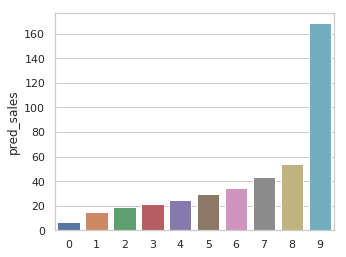

In [175]:
plt.figure(figsize=(5,4))
sns.barplot(x=df.index,y='pred_sales',data=df)

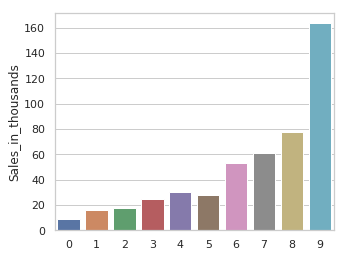

In [176]:
plt.figure(figsize=(5,4))
sns.barplot(x=df.index,y='Sales_in_thousands',data=df)

Since there is anamoly, that is the rank/order is broken - staircase broken at 5th decile in sales_in_thousands plot, hence model not performing well.